# Uncertainty of efficiency  from fitted decay yields

We derive an approximate formula to compute the uncertainty of the efficiency computed from fitted yields of some decays. The formula is suitable to draw error bars in plots.

In [1]:
#!pip install numpy iminuit numba_stats matplotlib scipy sympy joblib
import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL, NormalConstraint
from numba_stats import bernstein, norm
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation
import joblib
from sympy import *

## Without background

I will re-derive the common normal approximation for the uncertainty of an efficiency, see [Wikipedia](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) for details, in a particular way that will make the generalization to the case with background clear.

The first insight is that the efficiency can be written in terms of two independently Poisson-distributed numbers, the number of successes $n_1$ and failures $n_2$,

$$
\epsilon = \frac{n_1}{n_1 + n_2} = \frac{n_1}{n},
$$

with $n = n_1 + n_2$.

In the typical particle physics experiment, die total number of events is not fixed, since the measurement is fundamentally a rate measurement (one waits a fixed time and counts independent events that occur in that time. In that case, the two numbers are indeed independently Poisson distributed.

In a particular sample, the sample value $\hat n_k$ will deviate from the expectation value $n_k$ by a random offset $d_k = \hat n_k - n_k$, which has an effect on the estimator $\hat \epsilon(\hat n_1, \hat n_2) = \hat n_1 / (\hat n_1 + \hat n_2)$, that we can evaluate by expanding the estimator around the true value in a two-dimensional Taylor series around $\hat n_k = n_k$,

$$
\hat \epsilon = \sum_{i=0}^\infty\sum_{j=0}^\infty \frac {d_1^i \, d_2^j}{i! \, j!} \frac{\partial^{i+j} \hat \epsilon}{\partial \hat n_1^i \partial \hat n_2^j} (n_1, n_2)
$$

This is up to third order in $d$,

$$
\begin{aligned}
\hat \epsilon - \epsilon &= d_1 \frac{\partial \epsilon}{\partial n_1} + d_2 \frac{\partial \epsilon}{\partial n_2} \\
&+ \frac 12 \left( d_1^2 \frac{\partial^2 \epsilon}{\partial n_1^2} + 2 d_1 d_2 \frac{\partial^2 \epsilon}{\partial n_1 \partial n_2} + d_2^2 \frac{\partial^2 \epsilon}{\partial n_2^2} \right) \\
&+ \frac 16 \left(
d_1^3 \frac{\partial^3 \epsilon}{\partial n_1^3} + 
3 d_1^2 d_2 \frac{\partial^3 \epsilon}{\partial n_1^2 n_2} +
3 d_1 d_2^2 \frac{\partial^3 \epsilon}{\partial n_1 n_2^2} +
d_2^3 \frac{\partial^3 \epsilon}{\partial n_2^3}
\right) \\
&+ O(d^4)
\end{aligned}.
$$

Let's compute this expression with SymPy.

In [2]:
def bivariate_series(expr, x, y, dx, dy, order):
    return sum(
        sum(
            dx ** i * dy ** j / 
            (factorial(i) * factorial(j)) *
            diff(expr, x, i, y, j)
            for i in range(order + 1) if i + j <= order
        ) for j in range(order + 1)
    )

In [3]:
n1, n2, n = symbols("n_1 n_2 n", real=True, positive=True)
d1, d2 = symbols("d_1 d_2", real=True)

eps = n1 / (n1 + n2)

delta_eps = bivariate_series(eps, n1, n2, d1, d2, 3) - eps
delta_eps = delta_eps.subs(n1 + n2, n)
delta_eps

d_1**3*(1 - n_1/n)/n**3 + d_1**2*d_2*(2 - 3*n_1/n)/n**3 + d_1**2*(-1 + n_1/n)/n**2 + d_1*d_2**2*(1 - 3*n_1/n)/n**3 + d_1*d_2*(-1 + 2*n_1/n)/n**2 + d_1*(1/n - n_1/n**2) - d_2**3*n_1/n**4 + d_2**2*n_1/n**3 - d_2*n_1/n**2

In [4]:
def expectation(expr, args, replacements):
    poly = expr.as_poly(args)
    expr2 = []
    for powers, coef in poly.terms():
        x = prod(
            (1 if pi == 0 else replacements[argi ** pi])
            for pi, argi in zip(powers, args)
        )
        expr2.append(coef * x)
    return sum(expr2)

To compute the variance $\text{var}(\hat \epsilon)$ we need to square this and compute the expection on both sides. The expectation value $\langle d_k^j \rangle$ is the $j$-th central moment of the Poisson distribution. We compute these moments from the moment-generating function $M_X(t)$ of the Poisson distribution, using that $M_{\alpha X + \beta} = e^{\beta t} M_{X}(\alpha t)$.

In [5]:
mu, t = symbols("mu t", real=True)

# moment-generating function
mgf = exp(mu * (exp(t) - 1))

# central moment-generating function
cmgf = mgf * exp(-mu * t); cmgf

exp(-mu*t)*exp(mu*(exp(t) - 1))

In [6]:
# compute mapping d_k ** i -> E[d_k ** i]
replacements = {}
for i in range(1, 7):
    cm = diff(cmgf, t, i).subs(t, 0).expand()
    for di, ni in ((d1, n1), (d2, n2)):
        replacements[di ** i] = cm.subs(mu, ni)
replacements

{d_1: 0,
 d_2: 0,
 d_1**2: n_1,
 d_2**2: n_2,
 d_1**3: n_1,
 d_2**3: n_2,
 d_1**4: 3*n_1**2 + n_1,
 d_2**4: 3*n_2**2 + n_2,
 d_1**5: 10*n_1**2 + n_1,
 d_2**5: 10*n_2**2 + n_2,
 d_1**6: 15*n_1**3 + 25*n_1**2 + n_1,
 d_2**6: 15*n_2**3 + 25*n_2**2 + n_2}

Now we compute $\text{var}(\hat \epsilon) = \text{E}\big((\hat \epsilon - \epsilon)^2\big)$. Since SymPy does not know how to compute an expectation and that it is a linear operator, we need to resort to advanced expression manipulation in the following steps. We use that the expectation is linear and $\text{E}(n_i n_j) = \text{E}(n_i) \, \text{E}(n_j)$ for independent $n_i$ and $n_j$.

In [7]:
# replace powers of d_k with the corresponding central moments
expr2 = expectation(delta_eps ** 2, (d1, d2), replacements).expand()
expr2

n_1/n**2 - 2*n_1**2/n**3 - 2*n_1/n**3 + n_1**3/n**4 + n_1**2*n_2/n**4 + 13*n_1**2/n**4 + 3*n_1*n_2/n**4 + 3*n_1/n**4 - 20*n_1**3/n**5 - 20*n_1**2*n_2/n**5 - 26*n_1**2/n**5 - 8*n_1*n_2/n**5 - 2*n_1/n**5 + 9*n_1**4/n**6 + 18*n_1**3*n_2/n**6 + 58*n_1**3/n**6 + 9*n_1**2*n_2**2/n**6 + 61*n_1**2*n_2/n**6 + 29*n_1**2/n**6 + 3*n_1*n_2**2/n**6 + 11*n_1*n_2/n**6 + n_1/n**6 - 50*n_1**4/n**7 - 100*n_1**3*n_2/n**7 - 52*n_1**3/n**7 - 50*n_1**2*n_2**2/n**7 - 52*n_1**2*n_2/n**7 - 2*n_1**2/n**7 + 15*n_1**5/n**8 + 45*n_1**4*n_2/n**8 + 25*n_1**4/n**8 + 45*n_1**3*n_2**2/n**8 + 50*n_1**3*n_2/n**8 + n_1**3/n**8 + 15*n_1**2*n_2**3/n**8 + 25*n_1**2*n_2**2/n**8 + n_1**2*n_2/n**8

We keep only terms up to $O(1/n^2)$.

In [8]:
expr3 = []
for term in expr2.args:
    power = 0
    for x in term.args:
        if x is n1:
            power += 1
        elif x is n2:
            power += 1
        elif x.func is Pow:
            power += x.args[1]
    if power >= -2:
        expr3.append(term)
expr3 = sum(expr3); expr3

n_1/n**2 - 2*n_1**2/n**3 - 2*n_1/n**3 + n_1**3/n**4 + n_1**2*n_2/n**4 + 13*n_1**2/n**4 + 3*n_1*n_2/n**4 - 20*n_1**3/n**5 - 20*n_1**2*n_2/n**5 + 9*n_1**4/n**6 + 18*n_1**3*n_2/n**6 + 9*n_1**2*n_2**2/n**6

We further simplify by hand to obtain a simple result.

In [9]:
eps_var = expr3.subs(n1 + n2, n).expand()
eps_var = eps_var.subs(n, n1 + n2).factor()
eps_var

n_1*n_2*(n_1 + n_2 + 1)/(n_1 + n_2)**4

Up to the extra factor $(n + 1)/n$, this is the square of the formula in the [Wikipedia](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval),

$$
\sigma(\hat \epsilon) = \frac{1}{\sqrt{n}n} \sqrt{n_1 n_2}.
$$

The extra factor takes into account that the Poisson distribution is skewed. It vanishes if the Taylor-expansion of $\hat \epsilon$ is carried out only to second order.

The values $n_k$ that appear in the formula are the unknown expectation values and need to be replaced by their sample estimates $\hat n_k$ in practice. This is an application of the plug-in principle on which also bootstrap theory is based. There is a small bias involved in doing this, which we investigate further below.

Let's check this formula against the true standard deviation of $\hat \epsilon$ in toy simulations.

In [10]:
eps_var_py = lambdify((n1, n2), eps_var)

In [11]:
rng = np.random.default_rng(1)
eps = np.linspace(0, 1, 100)
data = {}
for n in (5, 10, 20, 50, 100, 1000):
    s1 = []
    s2 = []
    for epsi in eps:
        n1 = n * epsi
        n2 = n * (1 - epsi)
        k1 = rng.poisson(n1, size=10000)
        k2 = rng.poisson(n2, size=10000)
        ma = k1 + k2 > 0
        k1 = k1[ma]
        k2 = k2[ma]
        s1.append(np.std(k1 / (k1 + k2)))
        # it is important to average the variance instead of the standard deviation
        s2.append(np.mean(eps_var_py(k1, k2)) ** 0.5)
    data[n] = np.array((eps, s1, s2))

n=5 median deviation 0.13
n=10 median deviation 0.01
n=20 median deviation 0.00
n=50 median deviation -0.00
n=100 median deviation 0.00
n=1000 median deviation 0.00


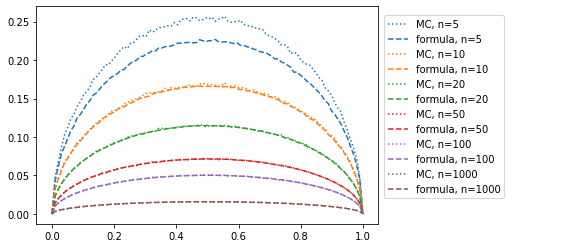

In [12]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"formula, {n=}")
    print(f"{n=} median deviation {np.median(s1[s2 > 0] / s2[s2 > 0]) - 1:.2f}")
plt.subplots_adjust(right=0.6)
plt.figlegend(loc=(0.68, 0.2));

There is some underestimation for small $n$, but the derived formula does well for $n > 10$, with deviations less than 1 %. This is usually sufficient to calculate error bars for efficiency plots.

### Bias-corrected estimator

As mentioned before, to obtain an estimator for the variance, we insert the estimates instead of the true values. Let's do that explicitly,

$$
\hat\sigma^2(\hat \epsilon) = \frac{\hat n_1 \hat n_2}{\hat n^3} \frac{\hat n + 1}{\hat n}.
$$

Although the $\hat n_i$ are unbiased estimates of the true values $n_i$, this estimator $\hat \sigma^2(\hat\epsilon)$ is now biased with respect to $\sigma^2(\hat \epsilon)$ because it is a non-linear function of unbiased estimates. We can compute this bias and correct it.

Generally speaking, let $\hat x$ be a vector of estimates of true values $x$, and let $R(x)$ be a function of $x$. We expand the function $R(\hat x)$ around $x$ in a Taylor series

$$
R(\hat x) = R(x) + R'_k(x) \, (\hat x - x)_k + \frac 1 2 R''_{kl}(x) \, (\hat x - x)_k (\hat x - x)_l + \frac 1 6 R'''_{klm}(x) \, (\hat x - x)_k (\hat x - x)_l (\hat x - x)_m + O\big((\hat x - x)^4\big),
$$

where Einstein summation convention is used and the $R'_k$, $R''_{kl}$, $R'''_{klm}$ are derivatives of $R$ with respect to the respective component of $x$. 

To compute the bias, we take the expectation on both sides,

$$
E[R(\hat x)] = R(x) + \frac 1 2 R''_{kl}(x) \, E[(\hat x - x)_k (\hat x - x)_l] + \frac 1 6 R'''_{klm}(x) \, E[(\hat x - x)_k (\hat x - x)_l (\hat x - x)_m] + O\big((\hat x - x)^4\big).
$$

The term with the first derivative $R'(x)_k$ vanishes, since $E[(\hat x - x)_k] = 0$. The terms $E[(\hat x - x)_k (\hat x - x)_l]$ are the components of the covariance matrix $C$ of $\hat x$. Computing the third order term is usually not required, since the bias is typically second order.

Knowing the bias $E[R(\hat x)] - R(x) = E[R(\hat x) - R(x)]$, we can form a bias-corrected estimate $\hat T(\hat x)$ by subtracting it to second order,

$$
T(\hat x) = R(\hat x) - E[R(\hat x) - R(x)] \\
T_1(\hat x) = R(\hat x) - \frac 1 2 R''_{kl}(x) \, C_{kl}.
$$

In our case, we have

$$
C_{kl} =
\begin{cases}
n_k & \text{for } k = l \\
0 & \text{otherwise}
\end{cases}.
$$

The computation with Sympy yields the following result.

In [60]:
n1, n2 = eps_var.args[:2]
n = symbols("n", real=True, positive=True)

expr1 = bivariate_series(eps_var, n1, n2, d1, d2, 2)

In [61]:
bias = (expectation(expr1, (d1, d2), replacements) - eps_var)
bias = bias.factor()
bias

2*n_1*n_2/(n_1 + n_2)**5

In [62]:
eps_var_bc = eps_var - bias
eps_var_bc = eps_var_bc.factor()
eps_var_bc

n_1*n_2*(n_1 + n_2 - 1)*(n_1 + n_2 + 2)/(n_1 + n_2)**5

In [63]:
eps_var_bc_py = lambdify((n1, n2), eps_var_bc)

In [64]:
rng = np.random.default_rng(1)
eps = np.linspace(0, 1, 100)
data = {}
for n in (5, 10, 20, 50, 100, 1000):
    s1 = []
    s2 = []
    s3 = []
    for epsi in eps:
        n_pass = rng.poisson(n * epsi, size=10000)
        n_fail = rng.poisson(n * (1 - epsi), size=10000)
        ma = n_pass + n_fail > 0
        n_pass = n_pass[ma]
        n_fail = n_fail[ma]
        s1.append(np.std(n_pass / (n_pass + n_fail)))
        # it is important to average the variance instead of the standard deviation
        s2.append(np.mean(eps_var_py(n_pass, n_fail)) ** 0.5)
        s3.append(np.mean(eps_var_bc_py(n_pass, n_fail)) ** 0.5)
    data[n] = np.array((eps, s1, s2, s3))

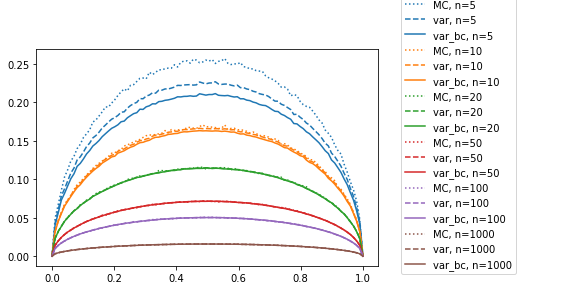

In [65]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2, s3) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"var, {n=}")
    plt.plot(eps, s3, "-", color=l.get_color(), label=f"var_bc, {n=}")
plt.subplots_adjust(right=0.6)
plt.figlegend(loc=(0.7, 0.06));

The bias corrected estimator does a little worse.

## With background

We now assume that the estimates $\hat n_\text{pass}$ and $\hat n_\text{fail}$ cannot obtained by direct counting, but need to be estimated from a fit that inclues a signal and background component. If the fit is unbiased, the average contribution from the background is zero, which we will assume, but it enlargens the uncertainty of the estimate.

We can model this by adding a random contribution from the background to our estimate,

$$
\hat n = n + z_1 \sigma_\text{poisson} + z_2 \sigma_\text{bkg} = n + z_1 \sqrt{n} + z_2 \sigma_\text{bkg},
$$

where $z_1$ and $z_2$ are independent random variables with zero mean and unit variance.

The expected variance of $\hat n$ then is

$$
\sigma^2(\hat n) = n + \sigma^2_\text{bkg}.
$$

In practice, estimating $\sigma^2_\text{bkg}$ directly is difficult, but fortunately, the left-hand side $\sigma^2(\hat n)$ can be estimated from the fit (MINUITs Hesse error). Thus we can compute an estimate for the unknown $\sigma^2_\text{bkg}$ with the formula,

$$
\sigma^2_\text{bkg} = \sigma^2(\hat n) -  n.
$$

In practice, we have to replace the expectation values $\sigma^2(\hat n)$ and $n$ with the corresponding estimates from the fit.

We insert this into the formula for $\hat \epsilon$ and get:

$$
\hat \epsilon = \frac{\hat n_\text{pass}}{\hat n_\text{pass} + \hat n_\text{fail}} = \frac{n_\text{pass} + z_1 \sqrt{n_\text{pass}} + z_2 \sigma_\text{bkg,pass}}{n_\text{pass} + n_\text{fail} + z_1 \sqrt{n_\text{pass}} + z_2 \sigma_\text{bkg,pass} + z_3 \sqrt{n_\text{fail}} + z_4 \sigma_\text{bkg,fail}}
$$

As before, the variance of $\hat \epsilon$ is computed via standard error propagation, using that the $z_i$ are independent and standard normal. This reflects the assumption that the background in both fits is independently sampled, which in practice is usually not exactly true. If the correlation can be estimated, it can be trivially included in the calculation, but I will not do this here.

$$
\sigma^2(\hat \epsilon) = \left[\left(\frac{\text{d}\hat \epsilon}{\text{d}z_1}\right)^2 + \left(\frac{\text{d}\hat \epsilon}{\text{d}z_2}\right)^2 + 
\left(\frac{\text{d}\hat \epsilon}{\text{d}z_3}\right)^2 +
\left(\frac{\text{d}\hat \epsilon}{\text{d}z_4}\right)^2
\right]_{z_1 = 0,\, z_2=0,\,z_3=0,\,z_4=0}.
$$

The calculation is even more tedious then before, so let's do it again with SymPy.

In [18]:
(n_pass, n_fail, sigma_pass, sigma_fail,
 sigma_bkg_pass, sigma_bkg_fail,
 z1, z2, z3, z4) = symbols(
    "n_pass n_fail sigma_pass sigma_fail "
    "sigma_bkg_pass sigma_bkg_fail "
    "z_1 z_2 z_3 z_4", real=True)

g = (n_pass + z1 * sqrt(n_pass) + z2 * sigma_bkg_pass) / \
    (n_pass + n_fail
     + z1 * sqrt(n_pass) + z2 * sigma_bkg_pass 
     + z3 * sqrt(n_fail) + z4 * sigma_bkg_fail); g

(sqrt(n_pass)*z_1 + n_pass + sigma_bkg_pass*z_2)/(sqrt(n_fail)*z_3 + n_fail + sqrt(n_pass)*z_1 + n_pass + sigma_bkg_fail*z_4 + sigma_bkg_pass*z_2)

In [19]:
g = g.subs([(sigma_bkg_pass, sqrt(sigma_pass ** 2  - n_pass)), 
            (sigma_bkg_fail, sqrt(sigma_fail ** 2 - n_fail))]); g

(sqrt(n_pass)*z_1 + n_pass + z_2*sqrt(-n_pass + sigma_pass**2))/(sqrt(n_fail)*z_3 + n_fail + sqrt(n_pass)*z_1 + n_pass + z_2*sqrt(-n_pass + sigma_pass**2) + z_4*sqrt(-n_fail + sigma_fail**2))

In [20]:
g_var = sum(diff(g, z) ** 2 for z in (z1, z2, z3, z4))
g_var = g_var.subs([(z1, 0), (z2, 0), (z3, 0), (z4, 0)])
g_var = g_var.simplify(); g_var

(n_fail**2*sigma_pass**2 + n_pass**2*sigma_fail**2)/(n_fail + n_pass)**4

We thus obtain

$$
\sigma(\hat \epsilon) = \frac{\sqrt{
n_\text{pass}^2 \, \sigma^2(\hat n_\text{fail}) +
n_\text{fail}^2 \, \sigma^2(\hat n_\text{pass})
}}{n^2},
$$

with $n = n_\text{pass} + n_\text{fail}$. In practice, $n_\text{pass}$, $\sigma^2(\hat n_\text{pass})$, ...  need to be replaced with their fit estimates.

As a check, I show how one can recover the previous formula, which is a special case, by setting $\sigma^2(n) = n$ (which means no background contribution),

$$
\sigma^2(\hat \epsilon) = \frac{
n_\text{pass}^2 \, \sigma^2(\hat n_\text{fail}) +
n_\text{fail}^2 \, \sigma^2(\hat n_\text{pass})
}{n^4} = 
\frac{
n_\text{pass}^2 \, n_\text{fail} +
n_\text{fail}^2 \, n_\text{pass}
}{n^4} =
\frac{
n_\text{pass} \, n_\text{fail} \, (n_\text{pass} + n_\text{fail})
}{n^4} =
\frac{
n_\text{pass} \, n_\text{fail}
}{n^3}.
$$

We again check the formula against Monte-Carlo simulations.

In [21]:
g_var_py = lambdify([n_pass, sigma_pass, n_fail, sigma_fail], g_var)

In [22]:
def model(x, b0, b1, b2, s, mu, sigma):
    nb = bernstein.scaled_cdf(x, (b0, b1, b2), -1, 1)
    ns = s * norm.cdf(x, mu, sigma)
    return ns + nb

@joblib.delayed
def run(eps, n):
    rng = np.random.default_rng(1)

    t1 = []
    t2 = []
    for itry in range(100):
        sigma = 0.1
        results = []
        for p in (eps, 1 - eps):
            s = rng.normal(0, sigma, size=rng.poisson(p * n))
            b = rng.uniform(-1, 1, size=n // 5)
            x = np.append(s, b)
            w, xe = np.histogram(x, bins=50, range=(-1, 1))
            cost = ExtendedBinnedNLL(w, xe, model)
            cost += NormalConstraint(("mu", "sigma"), (0, sigma), (1, 1))
            s_start = eps * n
            b_start = n
            m = Minuit(cost, 
                       b0=b_start, b1=b_start, b2=b_start,
                       s=s_start + 1, mu=0, sigma=sigma)
            m.limits[:4] = (0, None)
            m.limits["mu"] = (-0.5, 0.5)
            m.limits["sigma"] = (0.02, 1)
            m.migrad()
            if m.valid and m.accurate:
                results.append((m.values["s"], m.errors["s"]))
            else:
                print(n, f"{eps:.2f}", itry, "signal" if p == eps else "background",
                      "fit failed")
        if len(results) < 2:
            continue

        (n_pass, sigma_pass), (n_fail, sigma_fail) = results

        t1i = n_pass / (n_pass + n_fail)
        t2i = g_var_py(n_pass, sigma_pass, n_fail, sigma_fail)
        t1.append(t1i)
        t2.append(t2i)

    s1 = np.std(t1)
    s2 = np.mean(t2) ** 0.5
    return s1, s2

data = {}
eps = np.linspace(0, 1, 20)
with joblib.Parallel(-1) as pool:
    for n in (50, 100, 1000):
        s1, s2 = np.transpose(pool(run(epsi, n) for epsi in eps))
        data[n] = (eps, s1, s2)

n=50 median deviation 0.02
n=100 median deviation -0.03
n=1000 median deviation 0.04


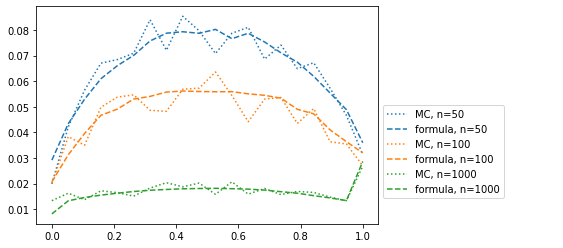

In [23]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"formula, {n=}")
    print(f"{n=} median deviation {np.median(s1[s2 > 0] / s2[s2 > 0]) - 1:.2f}")
plt.subplots_adjust(right=0.6)
plt.figlegend(loc=(0.68, 0.2));

Again, the derived formula does reasonably well with deviations around 5 % for $n > 50$. This is usually sufficient to calculate error bars for efficiency plots. There should be some bias for small $n$ as before, but it is difficult to see here due to other larger random scatter, since I generated less toys to keep the computation time on my laptop reasonable.


Finally, I compare the uncertainty estimates for various levels of background. The estimate with zero background corresponds to the estimate which one obtains with the naive formula.

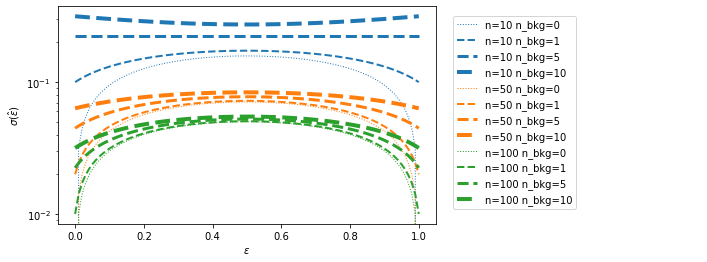

In [24]:
plt.figure(figsize=(14, 4))
eps = np.linspace(0, 1, 100)
for n in (10, 50, 100):
    n_pass = n * eps
    n_fail = n * (1 - eps)
    n_bkg = 0
    col = None
    for i, n_bkg in enumerate((0, 1, 5, 10)):
        s2 = g_var_py(n_pass, (n_pass + n_bkg) ** 0.5, n_fail, (n_fail + n_bkg) ** 0.5) ** 0.5
        col = plt.plot(eps, s2, "--" if i > 0 else ":", color=col,
                       lw=i+1, label=f"{n=} {n_bkg=}")[0].get_color()
plt.subplots_adjust(right=0.5)
plt.figlegend(loc=(0.64, 0.2))
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\sigma(\hat \epsilon)$")
plt.semilogy();

The error of using a formula that neglects the background contribution is largest when the efficiency is close to zero or one.

These are frequently the interesting cases. For example, the [tracking efficency of the LHCb experiment]((https://doi.org/10.1088/1748-0221/10/02/P02007)) is estimated from fits to decays in calibration samples and the efficiency is around 96 %, so that the difference in the formulas may impact the estimated uncertainty.

#### Formula for fits to selected and total events

Sometimes it is not easy to split the two samples into failed and passed cases, one has instead fits to the passed and total cases. 

In this case, we need to replace $n_\text{fail}$ and $\sigma^2(\hat n_\text{fail})$ in the main formula for $\sigma(\hat \epsilon)$, since we then only have $n = n_\text{pass} + n_\text{fail}$, $\sigma^2(\hat n)$, $n_\text{pass}$, and $\sigma^2(\hat n_\text{pass})$ available.

Since both estimates $\hat n_\text{pass}$ and $\hat n_\text{fail}$ are completely independent (again assuming independent background), their sum $\hat n = \hat n_\text{pass} + \hat n_\text{pass}$ must have the variance $\sigma^2(\hat n) = \sigma^2(\hat n_\text{pass}) + \sigma^2(\hat n_\text{fail})$.

Thus the formula for this case becomes

$$
\sigma(\hat \epsilon) = \frac{\sqrt{
n_\text{pass}^2 \, (\sigma^2(\hat n) - \sigma^2(\hat n_\text{pass})) +
(n - n_\text{pass})^2 \, \sigma^2(\hat n_\text{pass})
}}{n^2}.
$$